In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.tri as tri

from utils_mitgcm import open_mitgcm_ds_from_config

import eddytools_core as et

In [2]:
model = 'geneva_200m'
str_start_time = "2023-07-01T12:00:00.000000000"
str_end_time = "2023-07-01T22:00:00.000000000"
t_index = 3

# Open MITgcm results

In [3]:
mitgcm_config, ds_to_plot = open_mitgcm_ds_from_config('../config.json', model)

# Preprocess MITgcm inputs

In [4]:
grid_resolution_in_meter = ds_to_plot['XC'].values[1] - ds_to_plot['XC'].values[0]

In [5]:
data_aligned = et.detection_nencioli.preprocess_inputs(str_start_time, str_end_time, ds_to_plot, depth_index=0)

In [6]:
snapshot = data_aligned.isel(time=t_index)

# Curvature computations

In [11]:
x_plot, y_plot = np.meshgrid(snapshot['lon'], snapshot['lat'])
u_plot = snapshot['UVEL'].values
v_plot = snapshot['VVEL'].values

In [13]:
# Get grid spacing (assuming uniform spacing)
dx = np.gradient(x_plot, axis=1)  # longitude direction
dy = np.gradient(y_plot, axis=0)  # latitude direction

# Compute partial derivatives of u and v
du_dx = np.gradient(u_plot, axis=1) / dx
du_dy = np.gradient(u_plot, axis=0) / dy
dv_dx = np.gradient(v_plot, axis=1) / dx
dv_dy = np.gradient(v_plot, axis=0) / dy


In [19]:
numerator = u_plot * dv_dx - v_plot * du_dy + u_plot * du_dy - v_plot * dv_dx

denominator = (u_plot**2 + v_plot**2)**1.5

# Avoid division by zero
denominator[denominator == 0] = np.nan

curvature = numerator / denominator


In [32]:
%matplotlib notebook
plt.figure(figsize=(10, 6))
plt.streamplot(x_plot, y_plot, u_plot, v_plot, 
               density=6, color='black', linewidth=0.5, 
               arrowsize=0.7, arrowstyle='->')
plt.pcolormesh(x_plot, y_plot, curvature, vmin=-0.001, vmax=0.001)
plt.colorbar(label='Streamline Curvature')
plt.title('Curvature of Streamlines')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

<IPython.core.display.Javascript object>

# Curvature contour

In [24]:
from contourpy import contour_generator
def generate_contours(lat, lon, psi):
    # Generate contour levels
    levels = np.linspace(np.nanmin(psi), np.nanmax(psi), 50)
    # Generate contours
    cg = contour_generator(lon, lat, psi)
    contours = [cg.lines(level) for level in levels]
    # Initialize structures
    isolines = {}
    isolines_max = []
    # Flatten and store contour line vertices
    idx = 0
    for contour_level in contours:
        for segment in contour_level:
            if len(segment[:, 0]) > 3:
                isolines[idx] = {
                    "x": segment[:, 0].tolist(),
                    "y": segment[:, 1].tolist()
                }
            isolines_max.append(np.nanmax(segment[:, 1]))
            idx += 1
    return isolines, isolines_max

In [25]:
isolines_curv, isolines_speed_curv = generate_contours(snapshot['lat'].values, snapshot['lon'].values, curvature)

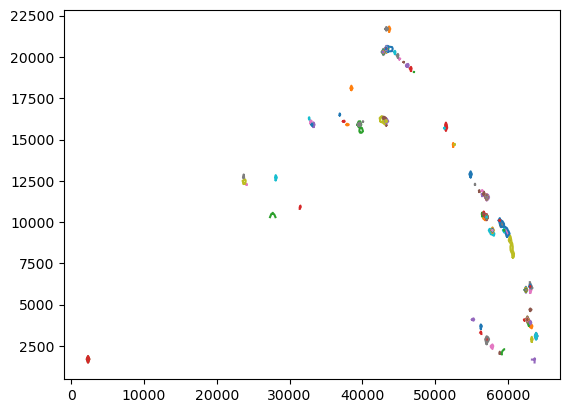

In [26]:
for i in isolines_curv:
    iso = isolines_curv[i]
    plt.plot(iso['x'], iso['y'])